In [1]:
import torch
import torch.nn as nn

import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid

from vq_vae_model import VQ_VAE

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device} device")

batch_size = 128

num_hiddens = 128
num_residual_hiddens = 32
num_residual_layers = 2

embedding_dim = 64
num_embeddings = 512

commitment_cost = 0.25

learning_rate = 1e-3
num_training_updates = 15000
decay = 0.99

model = VQ_VAE(in_channels=3, num_hiddens=num_hiddens, num_residual_layers=num_residual_layers, num_residual_hiddens=num_residual_hiddens, num_embeddings=num_embeddings, embedding_dim=embedding_dim, commitment_cost=commitment_cost, decay=decay)
model = model.to(device)

# Load the model
model.load_state_dict(torch.load("vq_vae_model.pth", map_location=device))

Using cpu device


/home/SENSETIME/hujiaqi/anaconda3/envs/NetFromScrach/lib/python3.12/site-packages/torch/cuda/__init__.py:118: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at /opt/conda/conda-bld/pytorch_1716905971214/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


<All keys matched successfully>

In [3]:
img_transformes = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (1.0, 1.0, 1.0)) # Normalize image to mean 0 and std 1
])

validation_data = datasets.CIFAR10(root='./data', train=False, download=True, transform=img_transformes)
valid_loader = torch.utils.data.DataLoader(validation_data, batch_size=32, shuffle=True, pin_memory=True)

train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=img_transformes)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, pin_memory=True)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
model.eval()

(valid_originals, _) = next(iter(valid_loader))
valid_originals = valid_originals.to(device)

vq_output_eval = model.pre_vq_conv(model.encoder(valid_originals))
_, valid_quantize, _, _ = model.vector_quantizer(vq_output_eval)
valid_reconstructions = model.decoder(valid_quantize)

In [5]:
(train_originals, _) = next(iter(train_loader))
train_originals = train_originals.to(device)

_, train_reconstructed, _= model(train_originals)


In [6]:
import matplotlib.pyplot as plt
import numpy as np
def show(img):
    npimg = img.numpy()
    fig = plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

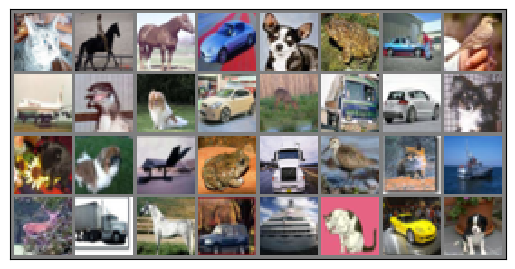

In [7]:
show(make_grid(valid_originals.cpu().data)+0.5, )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.07217771..1.0772076].


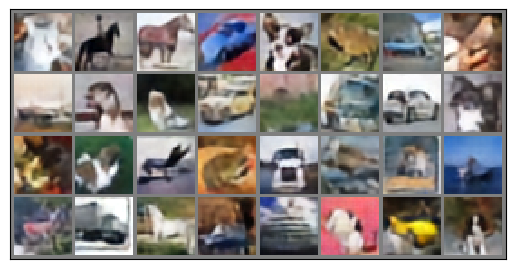

In [8]:
show(make_grid(valid_reconstructions.cpu().data)+0.5)

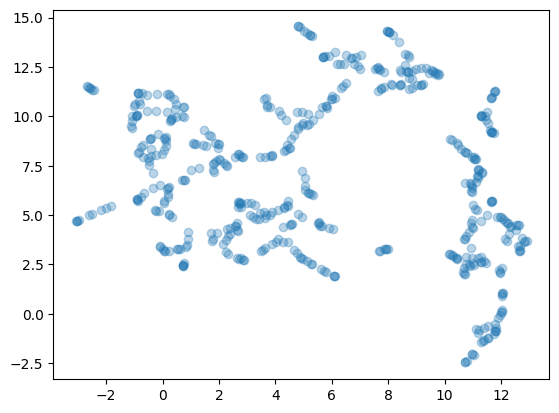

In [10]:
# %pip install umap-learn
import umap

# original embeddings are 64 dimensional, project down to 2d for visualization
proj = umap.UMAP(n_neighbors=3,min_dist=0.1,metric='cosine').fit_transform(model.vector_quantizer.embedding.weight.data.cpu())
plt.scatter(proj[:,0], proj[:,1], alpha=0.3)